In [1]:
dir_data = '../data'
dir_ckpt = '../ckpt/1668270620'
path_ckpt = f'{dir_ckpt}/last_ckpt.bin'

config = {
    'seed': 0,
    'k': 0.01,
    'epochs': 100,
    'hidden_dim': 10,
    'last_data': '2022-11-05',
    
    'ids': [0],
    
    'features': ['temperature', 'humidity', 'dew_point', 'wind_dir', 'wind_spd',
                'uv_idx', 'visibility', 'ceiling', 'cloudiness', 'precip_prob',
                'precip_1h', 'forecast', 'capacity', 'hour', 'year', 'month', 'day'],
    
    'optimizer': {
        'lr': 0.000,
        'weight_decay': 0.0
    },

    'scheduler': {
        'T_0': 100,
        'T_mult': 1,
        'eta_max': 0.0001,
        'T_up': 10,
        'gamma': 0.5,
    },

    'loss': {
        'loss': 'MeanStdLoss',
        'k': 1.0,
        'weights': (1.0, 0.0, 0.0),
    },

    'wandb': {
        'project': 'solar_power_prediction',
        'name': 'FineTuning(14)'
    }
}


In [2]:
import sys
sys.path.append('../')

from suncapturer.utils import seed_all
from suncapturer.solver import Trainer
from suncapturer.datasets import SolarDataset
from suncapturer.networks import WaveNet, CausalWaveNet

import os
import numpy as np
import pandas as pd
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.preprocessing import MinMaxScaler, minmax_scale


In [3]:
seed_all(config['seed'])

run_id = int(datetime.timestamp(datetime.now()))
config['run_id'] = run_id
config['dir_ckpt'] = os.path.join(dir_ckpt, str(run_id))

In [4]:
df = pd.read_csv(os.path.join(dir_data, 'forecasts1_16.csv'))
df = df.fillna(0)

start = datetime.strptime('2020-09-30', '%Y-%m-%d')
df['fcst_time'] = df['fcst_time'].str.split(' ').str[0]
df['fcst_time'] = pd.to_datetime(df['fcst_time'])
df['fcst_time'] = (df['fcst_time'] - start).dt.days

valid_start = df['fcst_time'].max() - 14
train_df = df[(df['id'].isin(config['ids'])) & (df['fcst_time'] < valid_start)].copy()
valid_df = df[(df['id'].isin(range(21))) & (df['fcst_time'] >= valid_start)].copy()
test_df = df[(df['fcst_time'] >= valid_start) & (df['id'] == 0)].copy()
config['valid_start'] = valid_start

with open(os.path.join(dir_ckpt, 'scaling_factor.pkl'), 'rb') as f:
    import pickle
    scaling_factor = pickle.load(f)

    for col, factors in scaling_factor.items():
        train_df[col] = (train_df[col] - factors[0]) / (factors[1] - factors[0])
        valid_df[col] = (valid_df[col] - factors[0]) / (factors[1] - factors[0])
        test_df[col] = (test_df[col] - factors[0]) / (factors[1] - factors[0])
        
os.makedirs(config['dir_ckpt'])
with open(os.path.join(config['dir_ckpt'], 'scaling_factor.pkl'), 'wb') as f:
    import pickle
    pickle.dump(scaling_factor, f)

In [5]:
train_dataset = SolarDataset(train_df, config['features'])
valid_dataset = SolarDataset(valid_df, config['features'])
test_dataset = SolarDataset(test_df, config['features'])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [6]:
model = WaveNet(len(config['features']), config['hidden_dim'])
ckpt = torch.load(path_ckpt)
model.load_state_dict(ckpt['model_state_dict'])

for param in model.parameters():
    param.requires_grad = False
    
model.conv_out.bias.requires_grad = True
# model.conv_out.weight.requires_grad = True

trainer = Trainer(model, config)
trainer.fit(train_loader, valid_loader, test_loader)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dongjinlee. Use `wandb login --relogin` to force relogin


/home/dongjin/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
  return F.conv1d(input, weight, bias, self.stride,


Epochs,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
LR,▁▂▅▆███████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁
test_Loss,▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇█████████████
test_Metric1,▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇█████████████
test_Metric2,██████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_Metric3,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_TotalMetric,▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇█████████████
train_Loss,████▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Metric1,████▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Metric2,████████████▅▅▅▅▅▅▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Metric3,▁▁▁▃▁▁▁▁▁▃▁▁▁▁█▁▁▁▁██▁█▃▁▁▁▁▁▁▃▁▁▁██▁▁▁█


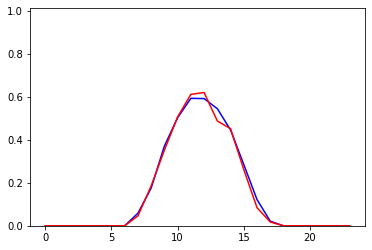

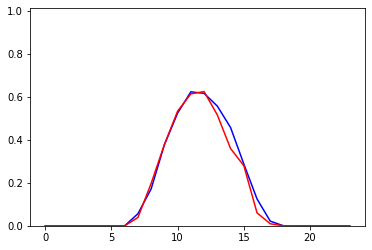

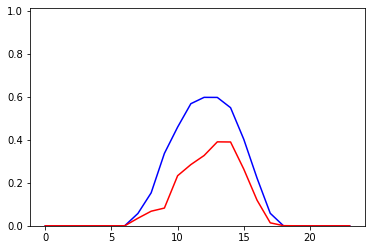

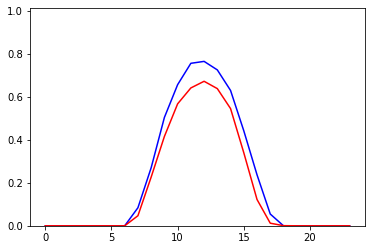

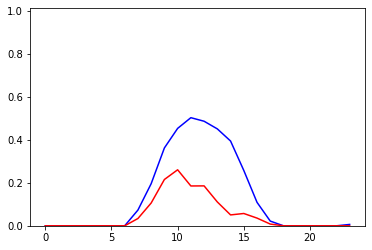

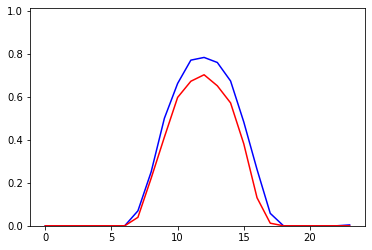

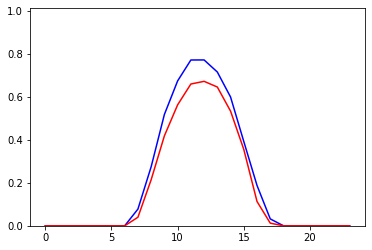

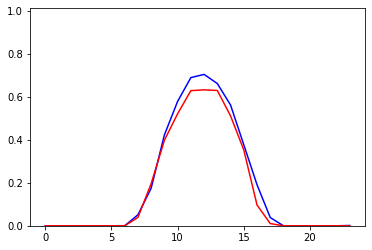

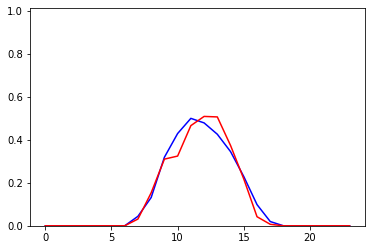

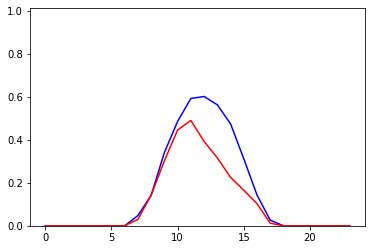

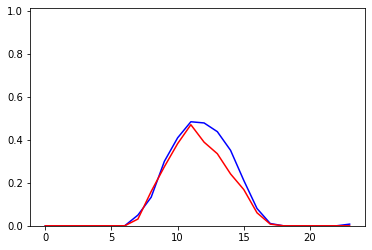

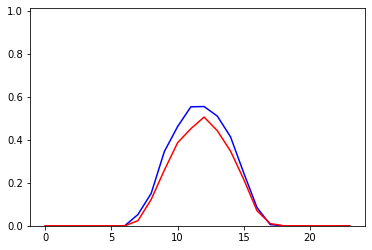

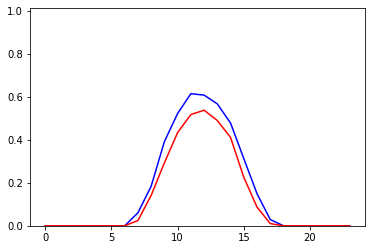

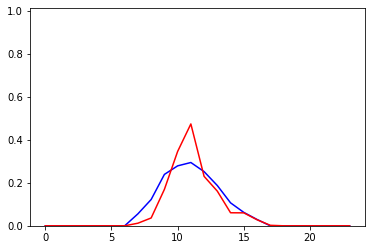

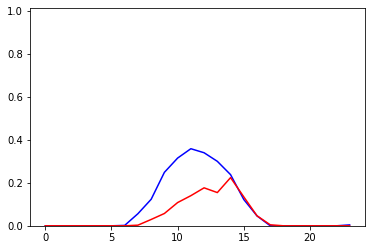

In [7]:
import matplotlib.pyplot as plt

for idx in range(0, 15):

    out = model(test_dataset[idx][0].unsqueeze(0))[0].detach().numpy()
    upper = out[:, 0] + config['k'] * out[:, 1]
    lower = out[:, 0] - config['k'] * out[:, 1]
    lower = lower * (lower > 0)
    target = valid_dataset[idx][1].numpy()

#     out, upper, lower, target = map(lambda x: 472.39 * x, [out, upper, lower, target])

    x = np.arange(24)
    plt.figure()
    plt.ylim(0, 1.01)
    plt.plot(x, out[:, 0], 'b-', label='pred')
    plt.plot(x, target, 'r-', label='true')
    plt.fill_between(x, y1=upper, y2=lower)
    plt.show()

In [8]:
from suncapturer.losses import CompetitionMetric

metric = CompetitionMetric()
scores = []
for idx in range(14):
    out = model(valid_dataset[idx:idx+1][0]).detach()
    bound = torch.zeros_like(out)
    bound[:, :, 0] = out[:, :, 0] - config['k'] * out[:, :, 1]
    bound[:, :, 1] = out[:, :, 0] + config['k'] * out[:, :, 1]

    target = valid_dataset[idx:idx+1][1]
    
    score = list(map(lambda x: x.item(), metric(bound, target).values()))
    scores.append(score)
np.stack(scores).mean(axis=0)

array([4.41646125e-01, 8.02992979e-01, 2.80259693e-44, 3.08319699e+00])